In [30]:
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

In [94]:
class GeneratorBlock(nn.Sequential):
    def __init__(self, in_channels,out_channels, kernel_size, stride, padding):
        super(GeneratorBlock, self).__init__()

        self.conv = nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
        # torch.nn.init.normal_(self.conv.weight, mean=0, std=0.02)
        self.bn = nn.BatchNorm2d(out_channels)
        # torch.nn.init.normal_(self.bn.weight, mean=0, std=0.02)
        nn.ReLU()


class Generator(nn.Module):
    def __init__(self, in_shape, n_features, latent_dim, device):
        super(Generator, self).__init__()
        self.in_shape = in_shape
        self.n_features = n_features
        self.latent_dim = latent_dim
        self.device = device

        self.net = nn.Sequential(
            GeneratorBlock(self.latent_dim,self.n_features*4,7,1,0),
            GeneratorBlock(self.n_features*4,self.n_features*2,4,2,1),
            GeneratorBlock(self.n_features*2, self.n_features,4,2,1),
            nn.ConvTranspose2d(self.n_features,1,3,1,1, bias=False),
            nn.Tanh()
        )
    def forward(self):
        X = torch.randn(64, 100).unsqueeze(-1).unsqueeze(-1)
        X =X.to(self.device)
        # print(X.shape)
        return self.net(X)

class DiscriminatorBlock(nn.Sequential):
    def __init__(self, in_channels,out_channels,kernel_size,stride,padding):
        super(DiscriminatorBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
        # torch.nn.init.normal_(self.conv.weight, mean=0, std=0.02)
        self.bn = nn.BatchNorm2d(out_channels)
        # torch.nn.init.normal_(self.bn.weight, mean=0, std=0.02)

        nn.LeakyReLU(0.2)



class Discriminator(nn.Module):
    def __init__(self, in_shape, latent_dim, n_features, leak, device):
        super(Discriminator, self).__init__()
        self.device = device
        self.net = nn.Sequential(
            nn.Conv2d(1, n_features, 4, 2,1, bias=False),
            nn.LeakyReLU(leak),
            DiscriminatorBlock(n_features, n_features*2, 4,2,1),
            DiscriminatorBlock(n_features*2, n_features*4, 4,2,1),
            nn.Conv2d(n_features*4, 1, 4, 1,1),
            # nn.Flatten(1, -1),
            nn.Sigmoid()
        )

    def forward(self,X):
        return self.net(X).view(-1,1).squeeze(1)




In [95]:
# DIscrim

X = torch.randn(128, 1,28,28)

c1 = nn.Conv2d(1, 32, 4, 2,1)
c2 = nn.Conv2d(32, 32*2, 4, 2,1)
c3 = nn.Conv2d(32*2, 32*4, 4, 2,1)
c4 = nn.Conv2d(32*4, 1, 4, 2,1)

X = c1(X)
print(X.shape)

X = c2(X)
print(X.shape)


X = c3(X)
print(X.shape)

X = c4(X)
print(X.shape)



torch.Size([128, 32, 14, 14])
torch.Size([128, 64, 7, 7])
torch.Size([128, 128, 3, 3])
torch.Size([128, 1, 1, 1])


In [96]:
import pickle
import torchvision
device = "cuda" if torch.cuda.is_available() else "cpu"
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(0.5, 0.5),
])
dataset = torchvision.datasets.MNIST("./data", train=True, download=True, transform=transforms)

In [106]:

gen = Generator((28,28,1), 32, 100,device)
gen = gen.to(device)
disc = Discriminator((28,28,1), 100, 32, 0.2,device)
disc=disc.to(device)
num_epochs = 5
loader = torch.utils.data.DataLoader(dataset,batch_size=128, shuffle=True)
optim_disc = torch.optim.Adam(disc.parameters(), lr=2e-4)
optim_gen = torch.optim.Adam(gen.parameters(), lr=2e-4)
loss_fn = nn.BCELoss()
gen.train()
disc.train()
gen_losses = []
disc_losses = []
for ep in range(num_epochs):
    print(f"Starting epoch {ep}")
    for src,_ in tqdm(loader):
        optim_disc.zero_grad()
        optim_gen.zero_grad()
        fake = gen()
        # real = src.permute(0,3,1,2)
        real = src
        disc_real = disc(real)
        # print(disc_real.shape)
        disc_fake = disc(fake)

        disc_real_loss = loss_fn(disc_real, torch.ones_like(disc_real))
        disc_fake_loss = loss_fn(disc_fake, torch.zeros_like(disc_fake))

        disc_loss = (disc_real_loss + disc_fake_loss) / 2
        disc_losses.append(disc_loss.item())

        disc_loss.backward(retain_graph=True)
        optim_disc.step()



        out = disc(fake)
        gen_loss = loss_fn(out, torch.ones_like(out))
        gen_losses.append(gen_loss.item())

        gen_loss.backward()
        optim_gen.step()





Starting epoch 0


100%|██████████| 469/469 [05:36<00:00,  1.39it/s]


Starting epoch 1


100%|██████████| 469/469 [06:05<00:00,  1.28it/s]


Starting epoch 2


100%|██████████| 469/469 [05:35<00:00,  1.40it/s]


Starting epoch 3


100%|██████████| 469/469 [05:23<00:00,  1.45it/s]


Starting epoch 4


100%|██████████| 469/469 [05:52<00:00,  1.33it/s]


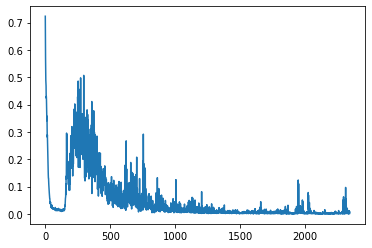

In [107]:
plt.plot(disc_losses)

In [108]:
torch.save({
    "epoch": ep,
    "disc_state": disc.state_dict(),
    "gen_state": gen.state_dict(),
    "gen_opt": optim_gen.state_dict(),
    "disc_opt": optim_disc.state_dict(),
    "gen_loss": gen_loss,
    "disc_loss": disc_loss
},"progress.pt")

In [109]:
from torchvision.utils import make_grid
def show_samples(samples, fname=None, nrow=10, title='Samples'):
    samples = (torch.FloatTensor(samples)).permute(0, 3, 1, 2)
    grid_img = make_grid(samples, nrow=nrow)
    plt.figure()
    plt.title(title)


    plt.imshow(grid_img.permute(1, 2, 0))
    plt.axis('off')

    if fname is not None:
        print("Yow")
    else:
        plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([64, 1, 28, 28])
tensor(1.) tensor(-1.)


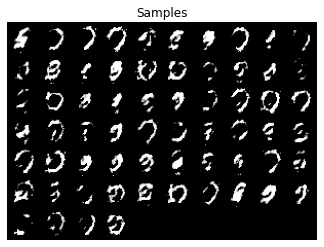

In [110]:
with torch.no_grad():
    gen.eval()
    preds = gen()
    print(preds.shape)
    print(torch.max(preds), torch.min(preds))

show_samples(preds.permute(0,2,3,1))